# Harris Corner Detector


In [1]:
#Import libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt



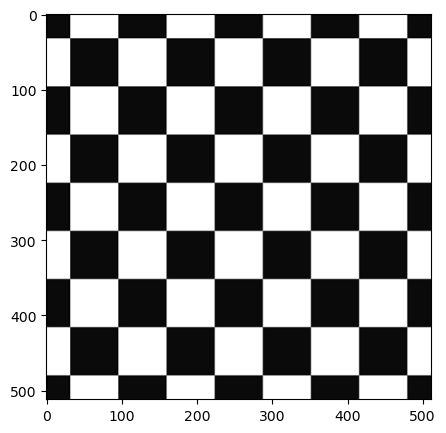

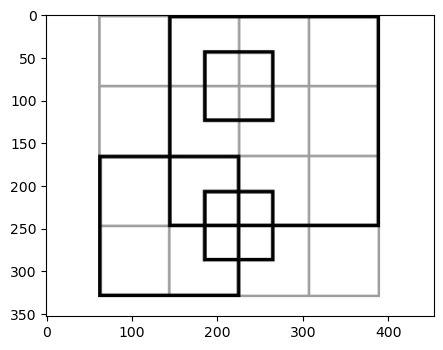

In [19]:
#Loading Image and gray scale conversion
test_img = cv2.imread('Box2.jpg')
test_img = cv2.cvtColor(src=test_img, code=cv2.COLOR_BGR2GRAY)

test_img2 = cv2.imread('box.jpg')
test_img2 = cv2.cvtColor(src=test_img2, code=cv2.COLOR_BGR2GRAY)

#plot the images
plt.figure(figsize=(5, 5))
plt.imshow(test_img, cmap='gray')
plt.figure(figsize=(5, 5))
plt.imshow(test_img2, cmap='gray')

In [20]:
#Convolution
def convolve2d(image, kernel):
  kernel = np.flipud(np.fliplr(kernel))

  k_sizeX, k_sizeY = kernel.shape
  im_sizeX, im_sizeY = image.shape

  #output image (convolved with image)
  output = np.zeros((im_sizeX,im_sizeY))
  for y in range(im_sizeY):
    if y > im_sizeY-k_sizeY:
      break

    for x in range(im_sizeX):
      if x > im_sizeX-k_sizeX:
        break

      output[int(np.floor((2*x+k_sizeX)/2)),int(np.floor((2*y+k_sizeY)/2))] = (kernel * image[x:x+k_sizeX, y:y+k_sizeY]).sum()

  return output


#gaussian smoothing
def gauss_smoothing(image):
    gauss_ker = np.array([ [1, 4, 7, 4, 1],[4, 16, 26, 16, 4],[7, 26, 41, 26, 7],[4, 16, 26, 16, 4],[1, 4, 7, 4, 1]])/273

    #convolve image with the gaussian kernel and normalize
    gauss_smooth_image = convolve2d(image,gauss_ker)
    gauss_smooth_image =  (gauss_smooth_image / gauss_smooth_image.max())*255
    return gauss_smooth_image 

#gradient operation 
def gradient_operation(image):
    
    # The sobel kernels for finding gradient (intensity change) in both directions
    Sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Sobely = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    #Convolve with sobel kernel to find gradient in both direction
    Gradient_x = convolve2d(image,Sobelx)
    Gradient_y = convolve2d(image,Sobely)
    
    #find the total magnitude and angle 
    Gradient = np.hypot(Gradient_x, Gradient_y)
    Gradient = Gradient/Gradient.max() * 255 #normalize
    angle = np.arctan2(Gradient_y,Gradient_x)
    
    return(Gradient, angle, Gradient_x, Gradient_y)


def harris_corner_detector(img,k,threshold):

    #find the horizontal and vertical gradient and plot
    gradient, gradient_angle, gradient_x, gradient_y = gradient_operation(img)
    
    #find the second moments and plot
    Ix2 = gradient_x**2
    Iy2 = gradient_y**2
    Ixy = gradient_x*gradient_y

    #smoothen 
    Sx2 = gauss_smoothing(Ix2)
    Sy2 = gauss_smoothing(Iy2)
    Sxy = gauss_smoothing(Ixy)
    
    #obtain response for each pixel
    detM = (Sx2*Sy2) - Sxy**2
    traceM = Sx2 + Sxy
    R = detM -k*(traceM**2)
    
    #threshold on value of R
    harris_corners = np.zeros(R.shape)
    harris_corners[R > threshold * R.max()] = 1
    
    #do non-maxima suppression and return the corners
    for i in range(1, harris_corners.shape[0] - 1):
        for j in range(1, harris_corners.shape[1] - 1):
            
            if harris_corners[i,j] and ( R[i, j] != np.max(R[i-1:i+2, j-1:j+2]) ):
                harris_corners[i,j] = 0
            
    return(harris_corners)


Text(0.5, 1.0, 'Image with corners')

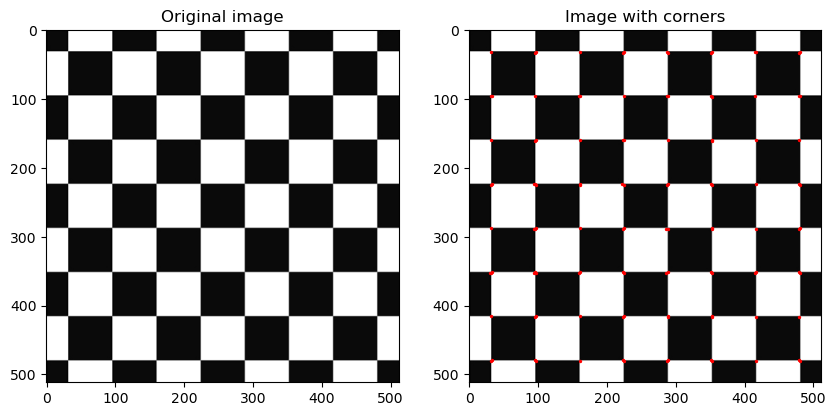

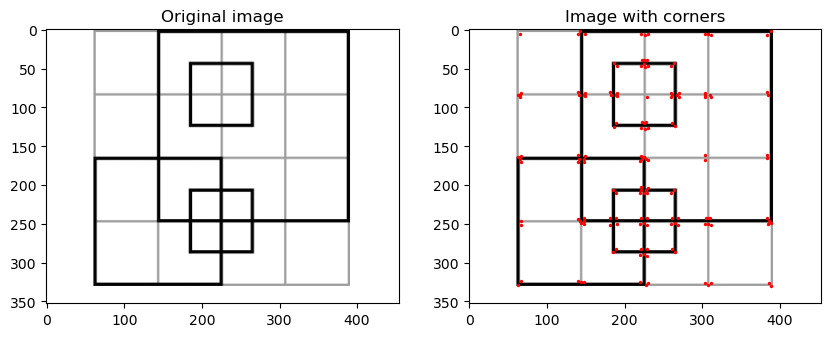

In [27]:
#test with box 
harris_corners = harris_corner_detector(test_img,0.04,0.3)

#plot the image and image with corners 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plt.imshow(test_img, cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2) 
plt.imshow(test_img, cmap='gray')

#plot the corner on top of image 
corner_ind = np.argwhere(harris_corners == 1.0)
for y, x in corner_ind:
    plt.scatter([x], [y], c='red',s=2)
plt.title('Image with corners')


#test with second box
harris_corners2 = harris_corner_detector(test_img2,0.04,0.005)

#plot the image and image with corners 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plt.imshow(test_img2, cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2) 
plt.imshow(test_img2, cmap='gray')
corner_ind2 = np.argwhere(harris_corners2 == 1.0)

for y, x in corner_ind2:
    plt.scatter([x], [y], c='red',s=2)
plt.title('Image with corners')


As indicated in the manual, the implementation included four major steps. First the horizontal and vertical gradients are found. Seondly, the moments are found using products of gradients and then gaussian smoothing is done resembling the sums of the products of derivatives at each pixel. Third, the response is found using the matrix involving the gaussian smoothend derivative products. Lastly, thresholding and non-maxima suppresion is done. The results above show that corners are successfully detected. In addition, interestion of two lines have corners at four points since the corners are in four direction of the intersection. The k (sensivity) factor can be adjusted to fit the image. If the image has high contrast and sharp corner low threshold can be used, but if the image has lots of noise, a higher threshold could work better to remove false corners. In the case of slanted lines, the threshold could be needed to be raised, since there will be a gradient in both direction for slanted lines unlike straight lines where gradient exist only horizontally or vertically. If the threshold is too low, the slanted lines could be confused with corners. 